In [4]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

# plt.rcParams['lines.linewidth'] = 0.5 

# mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 0.5, 'figure.dpi': 300})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from minizinc import Instance, Model, Solver, Status as mzStatus
import nest_asyncio
nest_asyncio.apply()

ModuleNotFoundError: No module named 'minizinc'

In [6]:

# Machine learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:

def plot_candles(wdf, ax=None, kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = .1, .02
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)    
    plt.xticks(rotation=30, ha='right')
    return ax

In [32]:
pair = 'BTC_USDT'
timeframe = '15m'

exchange = 'binance'
odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(13804, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2023-01-01 00:00:00,1672531200000,16541.77,16544.76,16520.00,16520.69,1172.53835
2023-01-01 00:15:00,1672532100000,16521.26,16545.70,16517.72,16544.19,1102.62888
2023-01-01 00:30:00,1672533000000,16544.19,16544.61,16508.39,16515.43,1365.65633
2023-01-01 00:45:00,1672533900000,16515.91,16536.84,16515.43,16529.67,724.01214


## PyKalma, works on python310

In [9]:
# Import a Kalman filter and other useful libraries
%load_ext autoreload
%autoreload 2
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


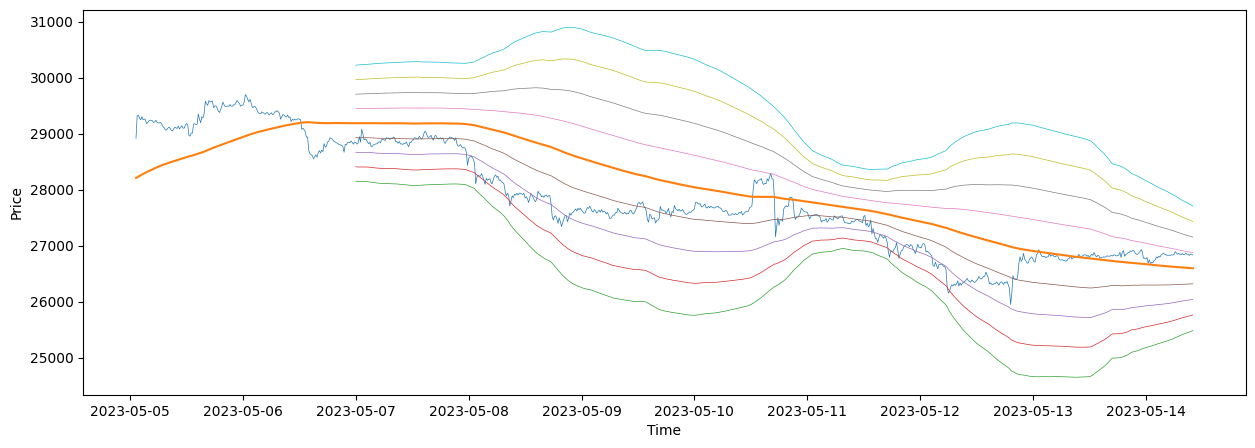

In [66]:

wlen = 1000
wstart = -2000
wend = wstart + wlen
wdf = odf.iloc[wstart:wend].copy()
# wdf = odf.iloc[-500:].copy()

######################
tau = 1 / wdf.shape[0]

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])
######################

# Run filter on close prices
state_means, state_covs = kf.filter(wdf.close.values)

wdf['kalman'] = state_means[:,0]
wdf['rstd'] = wdf.close.rolling(4 * 24 * 3).std()

wdf = wdf.iloc[100:]
plt.figure(figsize=(15,5))
plt.plot(wdf.close, lw=0.5)
plt.plot(wdf.kalman)
for i in [-4,-3,-2,-1,1,2,3,4]:
    plt.plot(wdf.kalman + i*wdf.rstd, lw=0.5)
# plt.legend(True)
plt.xlabel('Time')
plt.ylabel('Price');

<Axes: xlabel='dtime'>

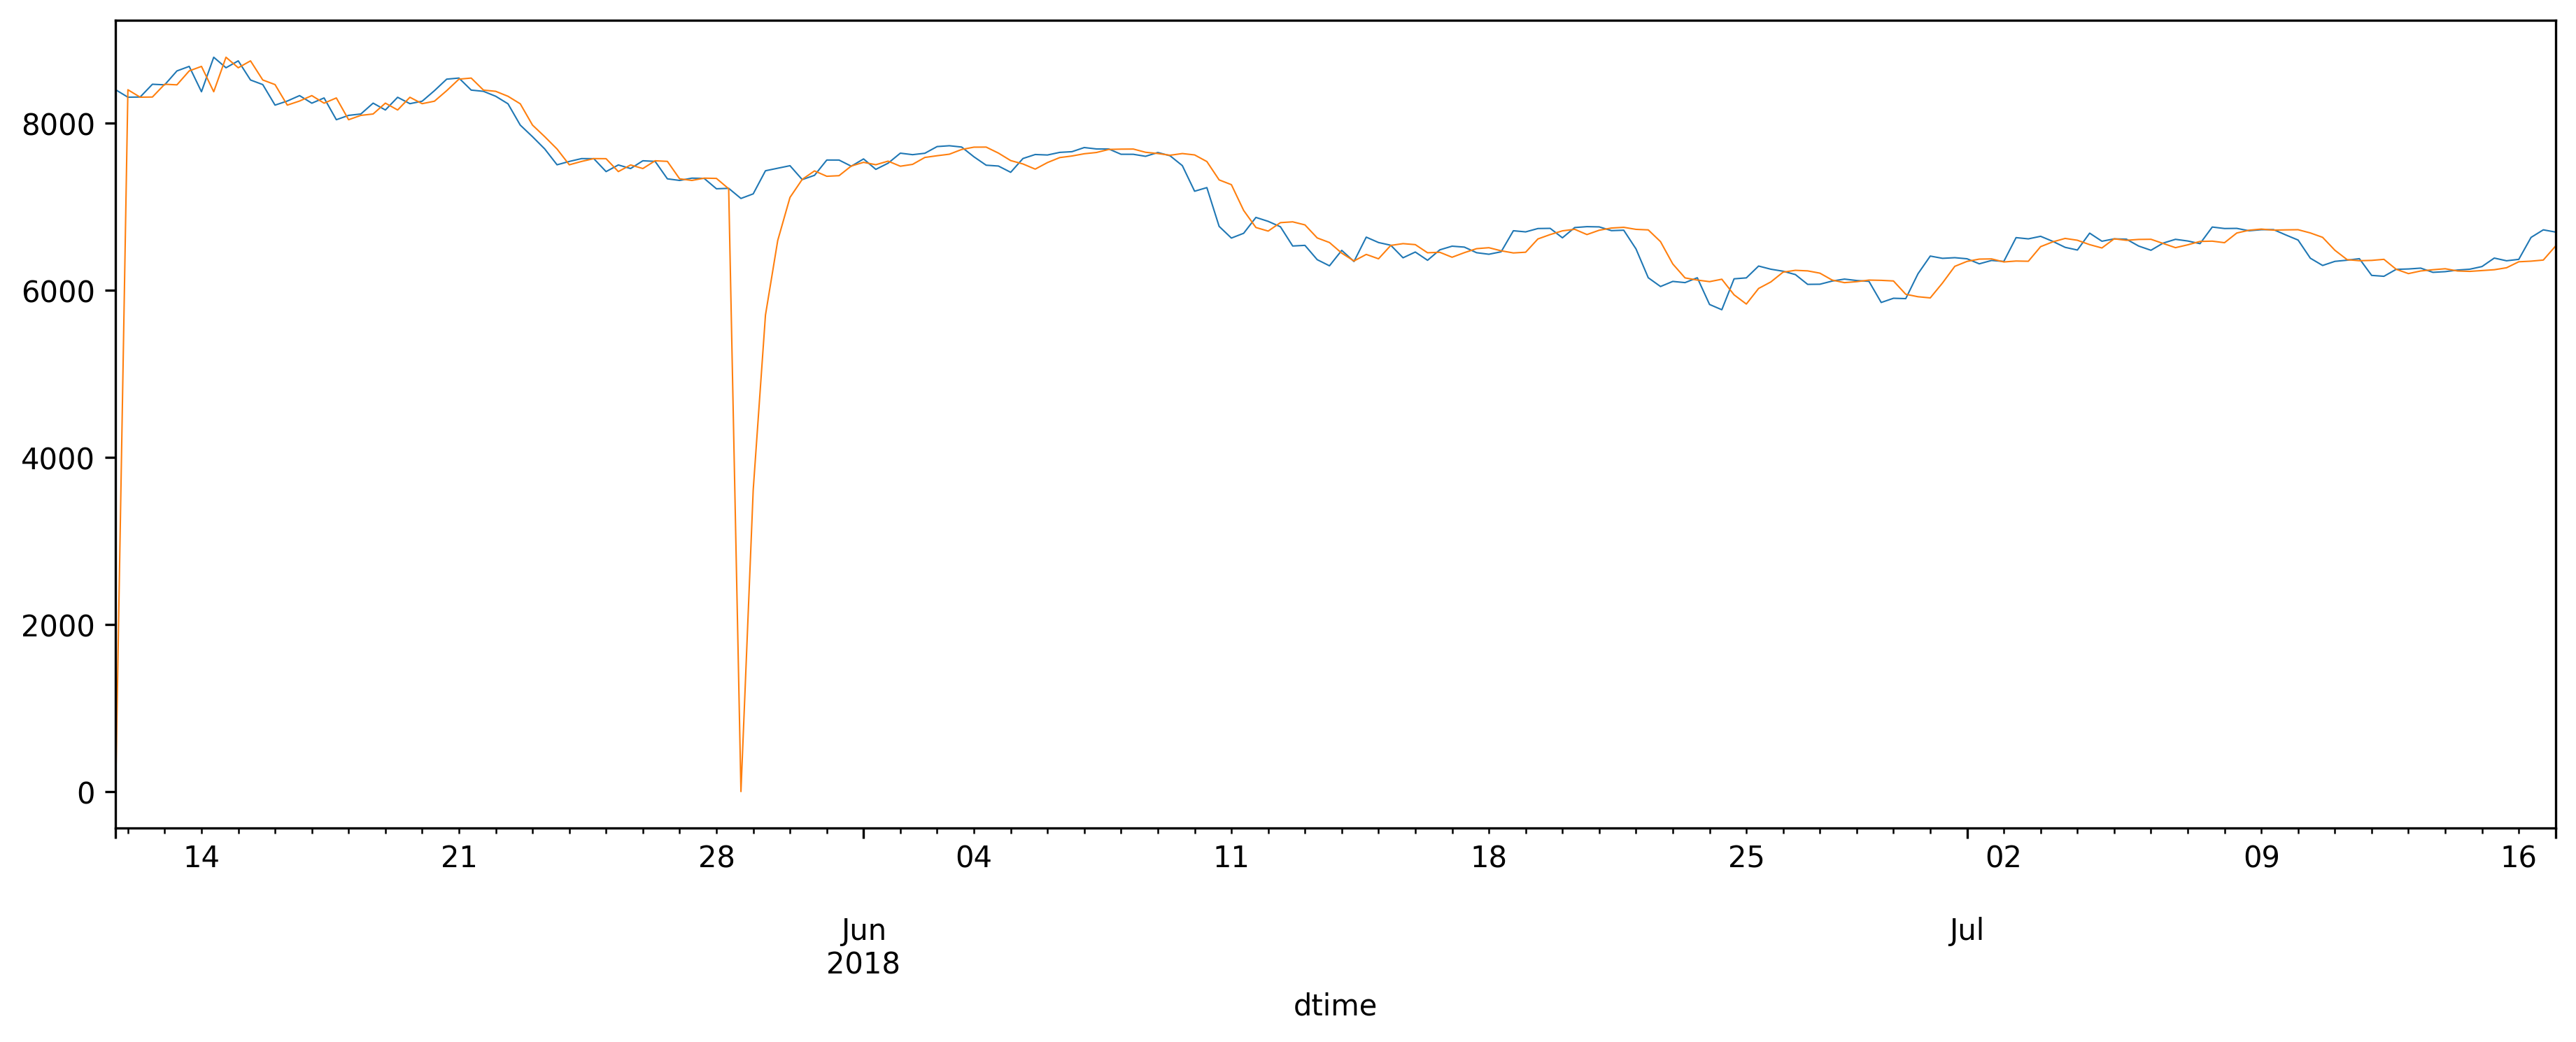

In [35]:
plt.figure(figsize=(15,5))
ax1 = wdf.close.plot()
wdf.kalman.plot(ax=ax1)

In [1]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

In [31]:
def mandala(n_iter, n_points, radius):
    """Creates a mandala figure using Voronoi tesselations.

    Parameters
    ----------
    n_iter : int
        Number of iterations, i.e. how many times the equidistant points will
        be generated.
    n_points : int
        Number of points to draw per iteration.
    radius : scalar
        The radial expansion factor.

    Returns
    -------
    fig : matplotlib.Figure instance

    Notes
    -----
    This code is adapted from the work of Audrey Roy Greenfeld [1]_ and Carlos
    Focil-Espinosa [2]_, who created beautiful mandalas with Python code.  That
    code in turn was based on Antonio Sánchez Chinchón's R code [3]_.

    References
    ----------
    .. [1] https://www.codemakesmehappy.com/2019/09/voronoi-mandalas.html

    .. [2] https://github.com/CarlosFocil/mandalapy

    .. [3] https://github.com/aschinchon/mandalas

    """
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.set_aspect('equal', adjustable='box')

    angles = np.linspace(0, 2*np.pi * (1 - 1/n_points), num=n_points) + np.pi/2
    # Starting from a single center point, add points iteratively
    xy = np.array([[0, 0]])
    for k in range(n_iter):
        t1 = np.array([])
        t2 = np.array([])
        # Add `n_points` new points around each existing point in this iteration
        for i in range(xy.shape[0]):
            t1 = np.append(t1, xy[i, 0] + radius**k * np.cos(angles))
            t2 = np.append(t2, xy[i, 1] + radius**k * np.sin(angles))

        xy = np.column_stack((t1, t2))

    # Create the Mandala figure via a Voronoi plot
    spatial.voronoi_plot_2d(spatial.Voronoi(xy), ax=ax)

    return fig

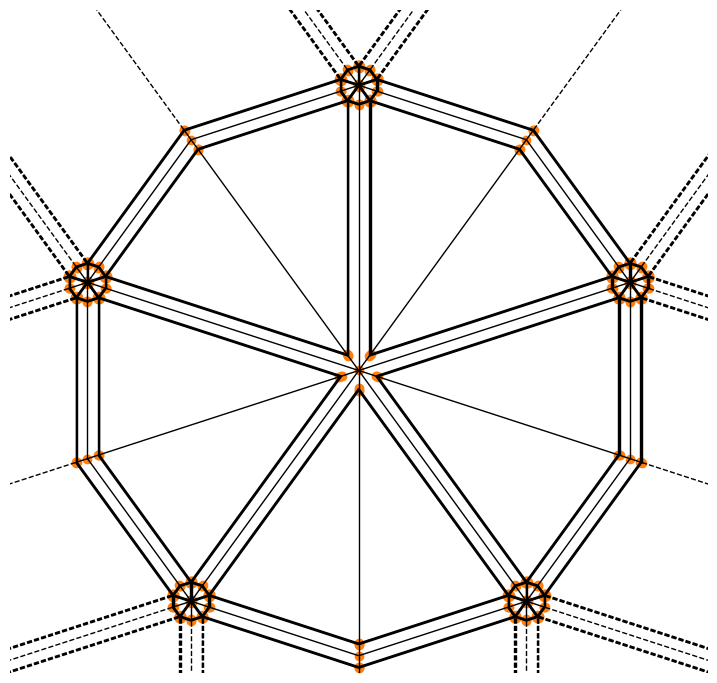

In [71]:
# Modify the following parameters in order to get different figures
import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams.update({'figure.dpi': 200, 'lines.linewidth': 0.1})
# plt.rcParams['lines.linewidth'] = 2
n_iter = 4
n_points = 5
radius = 15
fig = mandala(n_iter, n_points, radius)
plt.show()

In [57]:
list(mpl.rcParamsDefault.keys())

['_internal.classic_mode',
 'agg.path.chunksize',
 'animation.bitrate',
 'animation.codec',
 'animation.convert_args',
 'animation.convert_path',
 'animation.embed_limit',
 'animation.ffmpeg_args',
 'animation.ffmpeg_path',
 'animation.frame_format',
 'animation.html',
 'animation.writer',
 'axes.autolimit_mode',
 'axes.axisbelow',
 'axes.edgecolor',
 'axes.facecolor',
 'axes.formatter.limits',
 'axes.formatter.min_exponent',
 'axes.formatter.offset_threshold',
 'axes.formatter.use_locale',
 'axes.formatter.use_mathtext',
 'axes.formatter.useoffset',
 'axes.grid',
 'axes.grid.axis',
 'axes.grid.which',
 'axes.labelcolor',
 'axes.labelpad',
 'axes.labelsize',
 'axes.labelweight',
 'axes.linewidth',
 'axes.prop_cycle',
 'axes.spines.bottom',
 'axes.spines.left',
 'axes.spines.right',
 'axes.spines.top',
 'axes.titlecolor',
 'axes.titlelocation',
 'axes.titlepad',
 'axes.titlesize',
 'axes.titleweight',
 'axes.titley',
 'axes.unicode_minus',
 'axes.xmargin',
 'axes.ymargin',
 'axes.zmargi

In [68]:
(67+8) / (67+11+3+8)

0.8426966292134831

In [69]:
102 / (102 + 17)

0.8571428571428571

In [70]:
102 / (102+56)

0.6455696202531646

In [75]:
x = np.array([0, 1, 1, 3, 2, 1, 7, 23])
np.amax(x), np.bincount(x).size == np.amax(x)+1, np.bincount(x)


(23,
 True,
 array([1, 3, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1]))

In [4]:
import numpy as np
cfm = np.array([67,11,3,8]).reshape((-1,2))

array([[67, 11],
       [ 3,  8]])

In [19]:
s0 = np.array([8124])
v0 = np.array([[3916,4208]])

s1 = np.array([4596,3528])
v1 = np.array([[3796,800],[120,3408]])

s2 = np.array([4048,548,3456,72])
v2 = np.array([[3760,288],[36,512],[48,3408],[72,0]])

# np.transpose(v1)[0].sum() / 
v0.sum() == v1.sum() == v2.sum() == s0.sum() == s2.sum() == s1.sum()

a1 = (v1.T[0][0] + v1[1][1]) / v1.sum()
a2 = (v2[0][0] + v2[1][1] + v2[2][1] + v2[3][0]) / v2.sum()
a1,a2, a2 - a1

(0.8867552929591335, 0.9542097488921714, 0.0674544559330379)